In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt


N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 10 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 11
GAMMA = 1 / 2
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
#     f = (6*x - 2)**2 * np.sin(3*x - 4)
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return -f+5

In [4]:
dense_x = torch.linspace(-1, 2, 1024).reshape(-1, 1).to(**tkwargs)
dense_y = forrester(dense_x, noise=False)

In [5]:
X_obs = np.random.uniform(-1, 2, (10, 1))
y_obs = forrester(X_obs, noise=True)
tau = np.quantile(y_obs, q=GAMMA)

In [6]:
from botorch import fit_gpytorch_mll
from botorch.optim.optimize import optimize_acqf
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.utils.transforms import unnormalize, normalize

In [7]:
bounds = torch.tensor([[-1.], [2.]], **tkwargs)

def plot_gp(model, acq_func, X_obs, y_obs, ax_func, ax_acf):
    dense_x = torch.linspace(-1, 2, 1024).reshape(-1, 1)

    with torch.no_grad():
        posterior = model.posterior(normalize(dense_x, bounds))
        mean_pred = posterior.mean
        std_pred = posterior.variance.sqrt()

    with torch.no_grad():
        acq_vals = acq_func(normalize(dense_x, bounds).unsqueeze(1))

    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.plot(dense_x, mean_pred, label="mean prediction")
    ax_func.fill_between(
        dense_x.squeeze(),
        (mean_pred + 2*std_pred).squeeze(),
        (mean_pred - 2*std_pred).squeeze(),
        alpha=.3,
        label="uncertainty"
    )
    ax_func.scatter(X_obs[:-1], y_obs[:-1], marker='x', color='tab:red', label="observations")
    ax_func.scatter(X_obs[-1], y_obs[-1], marker='*', color='tab:orange', label="new observation")
    ax_func.set_xlim(*bounds.t())
    ax_func.set_title("GP-UCB")
    ax_func.legend()

    ax_acf.plot(dense_x, acq_vals)
    ax_acf.set_title("Acquisition function")
    ax_acf.set_xlim(*bounds.t())


def plot_lfbo(acq_vals, X_obs, y_obs, ax_func, ax_acf):
    dense_x = torch.linspace(-1, 2, 1024).reshape(-1, 1)

    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.scatter(X_obs[:-1], y_obs[:-1], marker='x', color='tab:red', label="observations")
    ax_func.scatter(X_obs[-1], y_obs[-1], marker='*', color='tab:orange', label="new observation")
    ax_func.set_xlim(*bounds.t())
    ax_func.set_title("LFBO-UCB")
    ax_func.legend()

    ax_acf.plot(dense_x, acq_vals)
    ax_acf.set_title("Acquisition function")
    ax_acf.set_xlim(*bounds.t())

In [8]:
from botorch.utils.sampling import draw_sobol_samples

def get_utility_from_gp(X_obs, y_obs, model, acq_func):
    with torch.no_grad():
        posterior = model.posterior(normalize(X_obs, bounds))
        mean_pred = posterior.mean
        utility = mean_pred + (acq_func.beta * torch.pi * 0.5).sqrt() * torch.abs(y_obs - mean_pred)
    return utility

def prepare_data_lfbo(X_obs, y_obs, model, acq_func):
    utility = get_utility_from_gp(X_obs, y_obs, model, acq_func)
    # x_m = draw_sobol_samples(bounds=bounds, n=len(X_obs), q=1).squeeze(1)
    # z_m = torch.empty(x_m.shape[0], 1).fill_(0)

    X_train = torch.concat([X_obs, X_obs])
    z_train = torch.concat(
        [torch.empty(len(X_obs), 1).fill_(0), torch.empty(len(X_obs), 1).fill_(1)]
    )
    w_train = torch.concat([torch.empty(len(X_obs), 1).fill_(1), utility])
    return X_train, z_train, w_train

In [14]:
import math
from tqdm import trange

from models import MLP


class LFBO_UCB:
    def __init__(
        self,
        input_dim,
        output_dim,
        device="cpu",
        dtype=torch.float64,
    ):
        self.tkwargs = {"device": device, "dtype": dtype}

        self.clf = MLP(
            input_dim=input_dim,
            output_dim=output_dim,
        )
        self.clf.to(**self.tkwargs)
 
    def fit(self, x, y, w, batch_size=64, S=500):
        optimizer = torch.optim.Adam(self.clf.parameters())
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

        train_tensors = [x, y, w]
        train_dataset = torch.utils.data.TensorDataset(*train_tensors)
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        N = len(x)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        self.clf.train()
        losses = []
        for epochs in trange(E):
            for _, (inputs, targets, weights) in enumerate(train_dataloader):
                optimizer.zero_grad(set_to_none=True)

                outputs = self.clf(inputs)
                batch_loss = loss_fn(
                    outputs, targets, weight=weights
                )
                batch_loss.backward()
                optimizer.step()
                losses.append(batch_loss.item())

        # plt.plot(losses)
        # plt.xlabel('Iterations')
        # plt.ylabel('Loss')
        self.clf.eval()

    def predict(self, X):
        self.clf.eval()
        with torch.no_grad():
            return torch.sigmoid(self.clf(X))

100%|██████████| 125/125 [00:00<00:00, 174.56it/s]


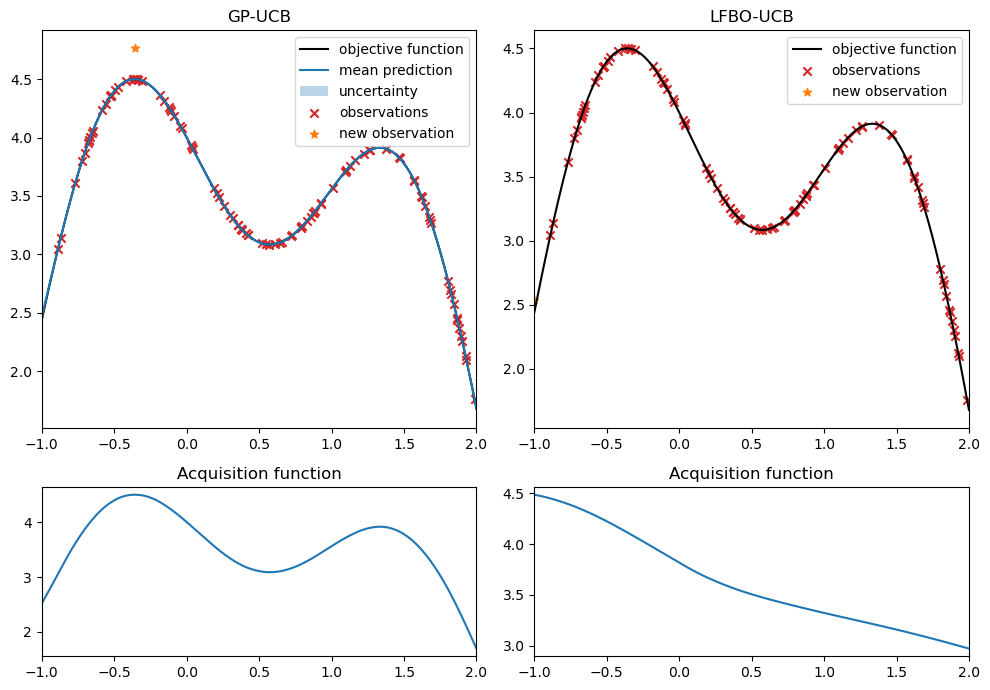

100%|██████████| 125/125 [00:00<00:00, 177.41it/s]


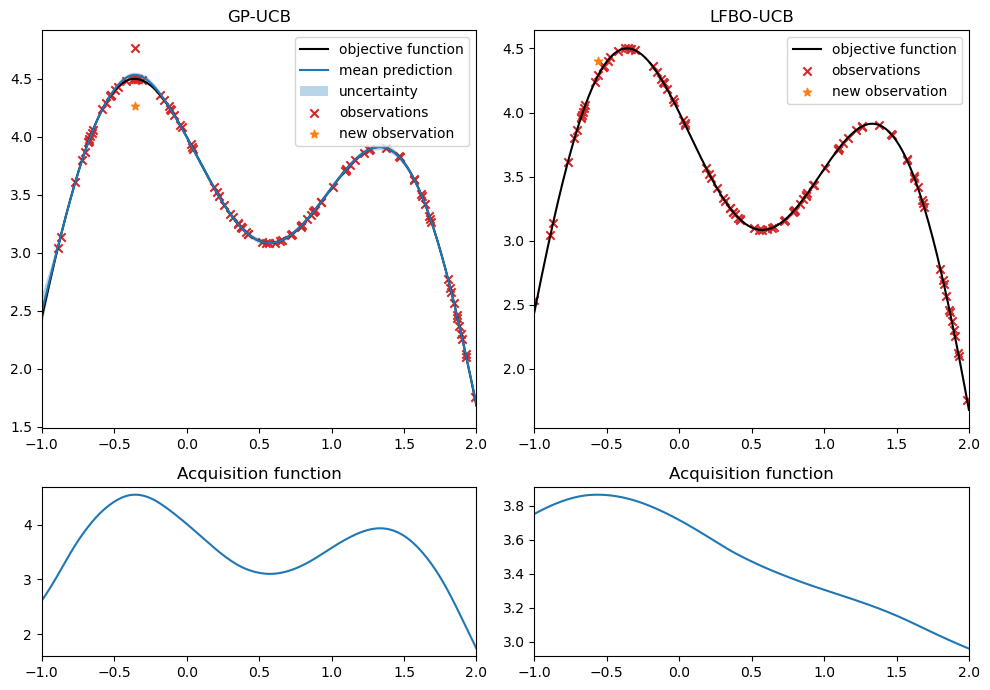

In [17]:
X_obs = np.random.uniform(-1, 2, (100, 1))
y_obs = forrester(X_obs, noise=False)

X_obs_gp, y_obs_gp = torch.from_numpy(X_obs), torch.from_numpy(y_obs)
X_obs_lfbo, y_obs_lfbo = torch.from_numpy(X_obs), torch.from_numpy(y_obs)


for _ in range(2):
    
    fig = plt.figure(figsize=(10, 7))
    ax_func_gp = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    ax_acf_gp = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
    ax_func_lfbo = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
    ax_acf_lfbo = plt.subplot2grid((3, 2), (2, 1), rowspan=1)

    x_norm = normalize(X_obs_gp, bounds)
    model = SingleTaskGP(
        x_norm, y_obs_gp, outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    acq_func = UpperConfidenceBound(
        model=model,
        beta=3,
        maximize=True
    )
    candidate, _ = optimize_acqf(
        acq_func,
        bounds=torch.tensor([[0.], [1.]]),
        q=1,
        num_restarts=5,
        raw_samples=512,
    )
    new_x = unnormalize(candidate.detach(), bounds=bounds)
    new_y = forrester(new_x, noise=True)
    X_obs_gp = torch.cat([X_obs_gp, new_x.reshape(-1, 1)])
    y_obs_gp = torch.cat([y_obs_gp, new_y.reshape(-1, 1)])
    plot_gp(model, acq_func, X_obs_gp, y_obs_gp, ax_func_gp, ax_acf_gp)

    x_norm = normalize(X_obs_lfbo, bounds)
    model = SingleTaskGP(
        x_norm, y_obs_lfbo, outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    acq_func = UpperConfidenceBound(
        model=model,
        beta=3,
        maximize=True
    )
    x, z, w = prepare_data_lfbo(X_obs_lfbo, y_obs_lfbo, model, acq_func)
    lfbo_ucb = LFBO_UCB(input_dim=1, output_dim=1)
    lfbo_ucb.fit(x, z, w, S=500)
    c = lfbo_ucb.predict(dense_x)
    acq = c / (1 - c)
    new_x = dense_x[torch.argmax(acq)]
    new_y = forrester(new_x, noise=True)
    X_obs_lfbo = torch.concat([X_obs_lfbo, new_x.reshape(-1, 1)])
    y_obs_lfbo = torch.concat([y_obs_lfbo, new_y.reshape(-1, 1)])
    plot_lfbo(acq, X_obs_lfbo, y_obs_lfbo, ax_func_lfbo, ax_acf_lfbo)

    plt.tight_layout()
    plt.show();

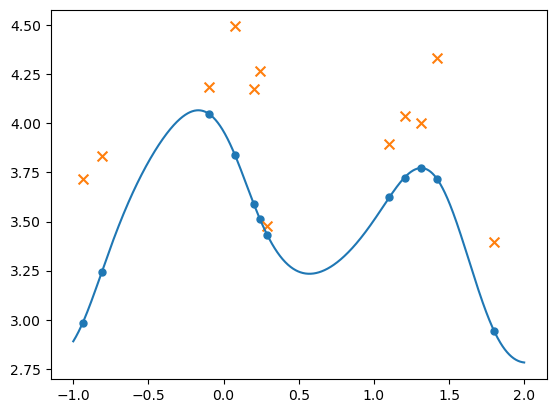

In [13]:
with torch.no_grad():
    posterior = model.posterior(normalize(X_obs_lfbo, bounds))
    mean_pred = posterior.mean
    plt.plot(dense_x, model.posterior(normalize(dense_x, bounds)).mean)
    plt.scatter(X_obs_lfbo, mean_pred, s=25)
    utility = mean_pred + (acq_func.beta * torch.pi * 0.5).sqrt() * torch.abs(y_obs_lfbo - mean_pred)
    plt.scatter(X_obs_lfbo, utility, s=50, marker='x')